Shapefile CRS: EPSG:4326
Number of features collected: 512
Number of targets collected: 512
Mean Squared Error: 0.1553398058252427
Accuracy: 0.9514563106796117
Classification Report:
                    precision    recall  f1-score   support

Crop_class_Garlic       1.00      0.91      0.95        11
Crop_class_Onion1       0.89      1.00      0.94        32
Crop_class_Wheat1       1.00      0.80      0.89        15
Crop_class_Wheat2       0.98      0.98      0.98        45

         accuracy                           0.95       103
        macro avg       0.97      0.92      0.94       103
     weighted avg       0.96      0.95      0.95       103



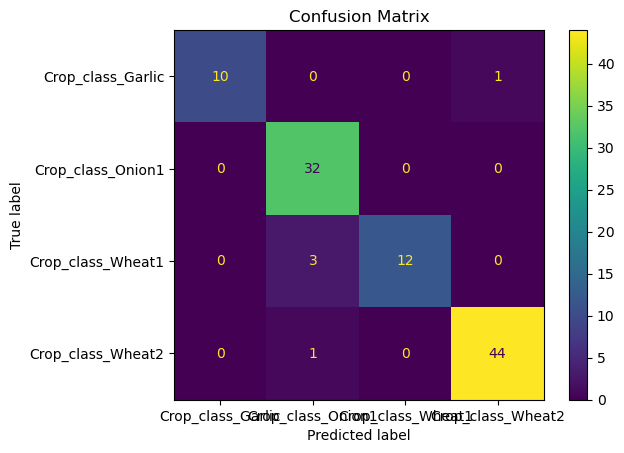

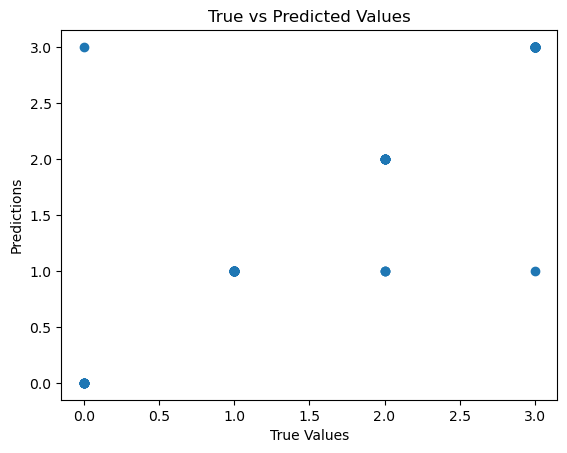

Label Mapping: {'Crop_class_Garlic': 0, 'Crop_class_Onion1': 1, 'Crop_class_Wheat1': 2, 'Crop_class_Wheat2': 3}


In [3]:
# Import Libraries
import os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from skimage.transform import resize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import tifffile as tiff

# Define the paths
raster_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_2"
shapefile_path = r"C:\Users\rishi\OneDrive\Desktop\merged for training\crop_data_merged.shp"
output_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_2"

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the CRS of the shapefile
print(f"Shapefile CRS: {gdf.crs}")

# Check if shapefile has the expected 'layer' column
assert 'layer' in gdf.columns, "Shapefile does not contain 'layer' column"

# Define the fixed shape for the features (e.g., 128x128)
fixed_shape = (128, 128)

def process_raster(filename):
    raster_path = os.path.join(raster_directory, filename)
    features = []
    targets = []

    try:
        with rasterio.open(raster_path) as src:
            print(f"Processing {filename}")
            print(f"Raster CRS: {src.crs}")

            if src.crs != gdf.crs:
                print("Reprojecting shapefile to match raster CRS")
                gdf_reprojected = gdf.to_crs(src.crs)
            else:
                gdf_reprojected = gdf

            raster_bounds = box(*src.bounds)
            print(f"Raster bounds: {raster_bounds.bounds}")

            intersecting_features = gdf_reprojected[gdf_reprojected.intersects(raster_bounds)]
            print(f"Number of intersecting features: {len(intersecting_features)}")

            if not intersecting_features.empty:
                for feature in intersecting_features.itertuples():
                    geom = feature.geometry
                    layer = feature.layer
                    try:
                        out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                        resized_image = resize(out_image[0], fixed_shape, mode='reflect', anti_aliasing=True)
                        features.append(resized_image.flatten())
                        targets.append(layer)
                    except Exception as e:
                        print(f"Error extracting data for feature {feature.Index}: {e}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

    return features, targets

# Use parallel processing to handle multiple files concurrently
results = Parallel(n_jobs=-1)(delayed(process_raster)(filename) for filename in os.listdir(raster_directory) if filename.endswith('.tif'))

# Combine results from all parallel processes
all_features = []
all_targets = []
for f, t in results:
    all_features.extend(f)
    all_targets.extend(t)

# Debugging: Print the number of features and targets collected
print(f"Number of features collected: {len(all_features)}")
print(f"Number of targets collected: {len(all_targets)}")

if len(all_features) == 0 or len(all_targets) == 0:
    raise ValueError("No samples collected. Ensure that the raster data and shapefile have corresponding overlaps.")

X = np.array(all_features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(np.array(all_targets))

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_scaled, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate recall and F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Generate and save output images
def save_predicted_image(original_image, predicted_label, output_dir, index):
    output_path = os.path.join(output_dir, f"predicted_image_{index}.tiff")
    tiff.imwrite(output_path, original_image.astype(np.float32))

# Create a directory for output images if it doesn't exist
output_images_directory = os.path.join(output_directory, "output_images")
os.makedirs(output_images_directory, exist_ok=True)

# Save a few sample images with predictions
num_samples_to_save = min(10, len(X_test))  # Save up to 10 images
for i in range(num_samples_to_save):
    original_image = X_test[i].reshape(fixed_shape)  # Reshape to the original shape
    predicted_label = y_pred[i]
    save_predicted_image(original_image, predicted_label, output_images_directory, i)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

# Visualize the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Shapefile CRS: EPSG:4326
Number of features collected: 512
Number of targets collected: 512
Mean Squared Error: 0.1553398058252427
Accuracy: 0.9514563106796117
Classification Report:
                    precision    recall  f1-score   support

Crop_class_Garlic       1.00      0.91      0.95        11
Crop_class_Onion1       0.89      1.00      0.94        32
Crop_class_Wheat1       1.00      0.80      0.89        15
Crop_class_Wheat2       0.98      0.98      0.98        45

         accuracy                           0.95       103
        macro avg       0.97      0.92      0.94       103
     weighted avg       0.96      0.95      0.95       103

Model saved to C:\Users\rishi\OneDrive\Desktop\best_model_sent2.joblib


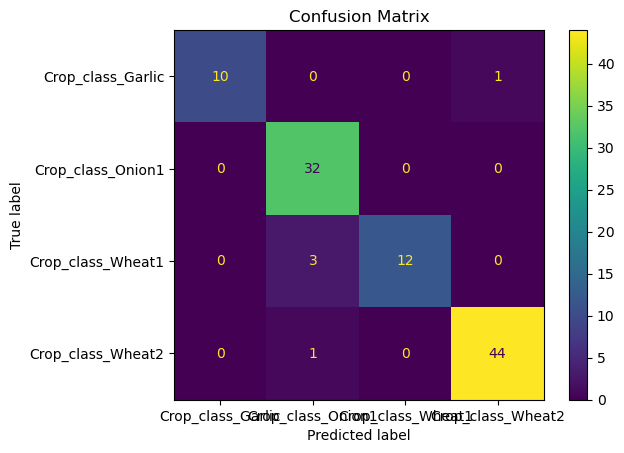

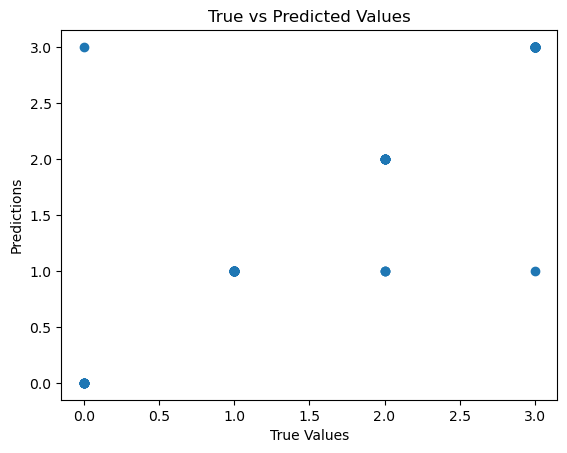

Label Mapping: {'Crop_class_Garlic': 0, 'Crop_class_Onion1': 1, 'Crop_class_Wheat1': 2, 'Crop_class_Wheat2': 3}


In [1]:
# Import Libraries
import os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from skimage.transform import resize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import tifffile as tiff
import joblib

# Define the paths
raster_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_2"
shapefile_path = r"C:\Users\rishi\OneDrive\Desktop\merged for training\crop_data_merged.shp"
output_directory = r"C:\Users\rishi\OneDrive\Desktop\sentinel_2"
model_save_path = r"C:\Users\rishi\OneDrive\Desktop\best_model_sent2.joblib"

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the CRS of the shapefile
print(f"Shapefile CRS: {gdf.crs}")

# Check if shapefile has the expected 'layer' column
assert 'layer' in gdf.columns, "Shapefile does not contain 'layer' column"

# Define the fixed shape for the features (e.g., 128x128)
fixed_shape = (128, 128)

def process_raster(filename):
    raster_path = os.path.join(raster_directory, filename)
    features = []
    targets = []

    try:
        with rasterio.open(raster_path) as src:
            print(f"Processing {filename}")
            print(f"Raster CRS: {src.crs}")

            if src.crs != gdf.crs:
                print("Reprojecting shapefile to match raster CRS")
                gdf_reprojected = gdf.to_crs(src.crs)
            else:
                gdf_reprojected = gdf

            raster_bounds = box(*src.bounds)
            print(f"Raster bounds: {raster_bounds.bounds}")

            intersecting_features = gdf_reprojected[gdf_reprojected.intersects(raster_bounds)]
            print(f"Number of intersecting features: {len(intersecting_features)}")

            if not intersecting_features.empty:
                for feature in intersecting_features.itertuples():
                    geom = feature.geometry
                    layer = feature.layer
                    try:
                        out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                        resized_image = resize(out_image[0], fixed_shape, mode='reflect', anti_aliasing=True)
                        features.append(resized_image.flatten())
                        targets.append(layer)
                    except Exception as e:
                        print(f"Error extracting data for feature {feature.Index}: {e}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

    return features, targets

# Use parallel processing to handle multiple files concurrently
results = Parallel(n_jobs=-1)(delayed(process_raster)(filename) for filename in os.listdir(raster_directory) if filename.endswith('.tif'))

# Combine results from all parallel processes
all_features = []
all_targets = []
for f, t in results:
    all_features.extend(f)
    all_targets.extend(t)

# Debugging: Print the number of features and targets collected
print(f"Number of features collected: {len(all_features)}")
print(f"Number of targets collected: {len(all_targets)}")

if len(all_features) == 0 or len(all_targets) == 0:
    raise ValueError("No samples collected. Ensure that the raster data and shapefile have corresponding overlaps.")

X = np.array(all_features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(np.array(all_targets))

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_scaled, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate recall and F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Save the trained model
model_metadata = {
    'model': model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'train_accuracy': accuracy
}
joblib.dump(model_metadata, model_save_path)
print(f"Model saved to {model_save_path}")

# Generate and save output images
def save_predicted_image(original_image, predicted_label, output_dir, index):
    output_path = os.path.join(output_dir, f"predicted_image_{index}.tiff")
    tiff.imwrite(output_path, original_image.astype(np.float32))

# Create a directory for output images if it doesn't exist
output_images_directory = os.path.join(output_directory, "output_images")
os.makedirs(output_images_directory, exist_ok=True)

# Save a few sample images with predictions
num_samples_to_save = min(10, len(X_test))  # Save up to 10 images
for i in range(num_samples_to_save):
    original_image = X_test[i].reshape(fixed_shape)  # Reshape to the original shape
    predicted_label = y_pred[i]
    save_predicted_image(original_image, predicted_label, output_images_directory, i)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

# Visualize the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)
